<a href="https://colab.research.google.com/github/shivangibithel/IRMiDis_Task2/blob/main/Naive_Bayes_Logistic_Regression_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with Naive Bayes, Logistic Regression, SVM

In [20]:
# pip install emoji --upgrade

In [21]:
import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#pre-processing of text
import string
import re

#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time

### Section 1: Load and explore the dataset

In [22]:
import pandas as pd
our_data = pd.read_csv("irmidis-2021-task2-train.csv")
from sklearn.utils import shuffle
our_data = shuffle(our_data)

In [23]:
our_data.head()

,id,tweet,label
2375,1326228710081458176,Upbeat news on a coronavirus vaccine and a win...,Neutral
2252,1325771093085392897,"Covid-19 vaccine candidate is 90% effective, s...",Neutral
1873,1326507186839822336,$HLT\nArgus upgrades Hilton Worldwide (NYSE:HL...,Neutral
2555,1328858473111691264,"@RandPaul Hey Senator Moron, are you maybe for...",ProVax
691,1325798458889039873,Honestly this is what all the anti vaxxers con...,ProVax


In [24]:
display(our_data.shape) #Number of rows (instances) and columns in the dataset
print(our_data["label"].value_counts()/our_data.shape[0]) #Class distribution in the dataset

(2792, 3)

Neutral    0.361748
ProVax     0.354943
AntiVax    0.283309
Name: label, dtype: float64


In [25]:
our_data['label'] = our_data.label.map({'Neutral':0, 'AntiVax':1, 'ProVax':2}) #relevant is 1, not-relevant is 0. 
our_data = our_data[["tweet","label"]] #Let us take only the two columns we need.
our_data.head()

,tweet,label
2375,Upbeat news on a coronavirus vaccine and a win...,0
2252,"Covid-19 vaccine candidate is 90% effective, s...",0
1873,$HLT\nArgus upgrades Hilton Worldwide (NYSE:HL...,0
2555,"@RandPaul Hey Senator Moron, are you maybe for...",2
691,Honestly this is what all the anti vaxxers con...,2


### Section 2: Text Pre-processing

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task. 

In [26]:
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): #doc is a string of text
    # doc = doc.replace("@", " ")
    # doc = doc.replace(" ", " ")
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # doc = " ".join([token for token in doc.split() if token not in stopwords])
    #remove punctuation and numbers
    return doc

In [27]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [28]:
def remove_url(data):
  url = re.compile("http[s]?\:\/\/.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+", re.UNICODE)
  return re.sub(url, '', data)

In [29]:
for i in range(len(our_data)):
  our_data.tweet.iloc[i] = remove_url(our_data.tweet.iloc[i])
  our_data.tweet.iloc[i] = clean(our_data.tweet.iloc[i])
  our_data.tweet.iloc[i] = remove_emojis(our_data.tweet.iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [30]:
our_data.head()

,tweet,label
2375,Upbeat news on a coronavirus vaccine and a win...,0
2252,Covid vaccine candidate is effective says man...,0
1873,HLT\nArgus upgrades Hilton Worldwide NYSEHLT t...,0
2555,RandPaul Hey Senator Moron are you maybe forge...,2
691,Honestly this is what all the anti vaxxers con...,2


### Section 3: Modeling

Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1 Split the data into training and test sets (75% train, 25% test)    
2 Extract features from the training data using CountVectorizer, which is a bag of words feature  implementation. We will use the pre-processing function above in conjunction with Count Vectorizer  
3 Transform the test data into the same feature vector as the training data.  
4 Train the classifier  
5 Evaluate the classifier  

In [31]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#Step 1: train-test split
X = our_data.tweet #the column text contains textual data to extract features from
y = our_data.label #this is the column we are learning to predict. 
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2792,) (2792,)
(2094,) (2094,)
(698,) (698,)


In [32]:
#Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)#use it to extract features from training data
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
#i.e., the dimension of our feature vector is 49753!

(2094, 7648) (698, 7648)


In [33]:
#Step 3: Train the classifier and predict for test data
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm

CPU times: user 4.02 ms, sys: 1.01 ms, total: 5.02 ms
Wall time: 4.83 ms


In [34]:
print(y_pred_class)

[2 2 0 0 2 2 1 2 0 1 0 2 1 1 2 1 2 1 1 2 1 2 0 2 1 1 2 2 0 1 1 2 0 2 2 2 2
 2 1 0 1 0 2 2 1 1 1 2 2 0 1 2 1 2 2 1 1 1 1 1 2 1 0 1 1 2 2 0 1 2 2 2 2 0
 0 1 2 2 2 2 1 1 0 2 1 2 2 1 0 2 2 2 2 0 1 1 1 2 0 0 1 2 1 0 2 1 2 1 0 1 1
 0 1 2 0 2 1 0 1 1 0 2 1 0 2 2 1 0 0 0 0 2 1 1 0 1 1 2 0 0 2 2 0 1 0 0 0 0
 0 2 1 2 0 0 1 2 0 2 1 0 2 2 0 2 2 2 2 1 0 0 0 2 1 2 2 1 0 2 2 2 0 2 1 0 2
 0 1 2 1 0 0 2 0 2 2 2 2 1 1 0 1 2 0 2 0 0 1 2 1 2 2 2 2 0 2 0 2 1 1 0 0 2
 2 0 0 1 2 0 2 1 2 2 1 2 1 2 0 1 0 0 2 2 1 2 1 0 1 1 1 2 2 2 2 2 0 0 0 0 2
 0 2 1 2 0 0 1 1 0 1 1 0 0 2 2 0 0 2 1 2 1 2 2 2 2 2 0 2 2 2 0 1 0 1 2 2 2
 2 1 1 0 2 0 2 0 1 0 2 2 0 0 2 0 1 2 0 2 0 0 1 0 0 2 2 2 0 2 0 1 0 0 2 1 2
 2 0 1 2 1 1 2 1 0 2 1 2 2 0 0 2 2 2 1 1 1 0 0 1 2 1 2 2 0 0 1 1 2 0 2 0 2
 2 2 2 2 2 2 0 1 1 0 1 0 2 1 2 2 1 1 1 1 0 2 2 1 2 0 2 0 2 1 2 2 1 0 1 2 2
 2 1 1 0 2 1 0 1 2 1 0 0 0 2 0 0 2 1 2 2 1 0 0 2 0 2 1 0 0 2 1 1 1 1 0 0 2
 0 0 0 2 0 0 0 1 2 1 2 0 0 1 2 2 2 0 1 2 0 0 2 2 0 0 1 1 2 0 1 0 0 2 1 1 1
 2 2 0 1 0 0 0 2 0 1 1 0 

Accuracy:  0.6962750716332379


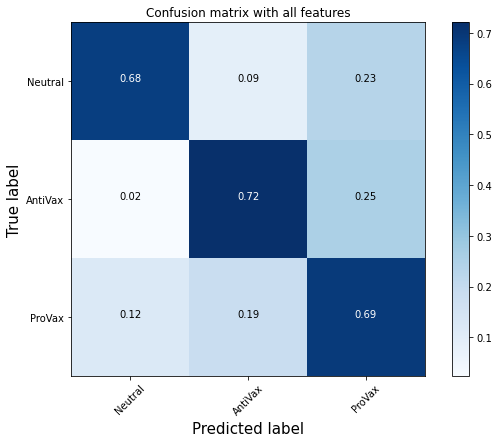

In [35]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
#Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Neutral','AntiVax','ProVax'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
#Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
# print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum. 

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.01 ms
Accuracy:  0.7106017191977078


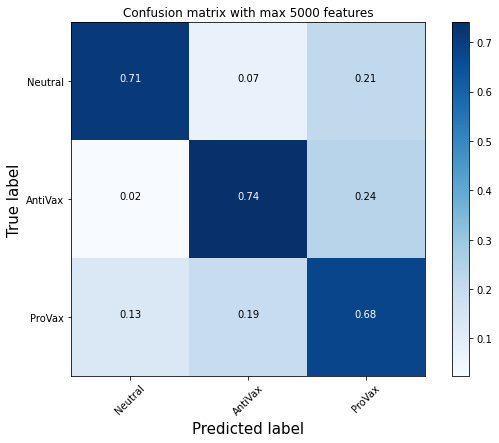

In [36]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)#train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm)#make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Neutral','AntiVax','ProVax'],normalize=True,
                      title='Confusion matrix with max 5000 features')

Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset. 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.7277936962750716


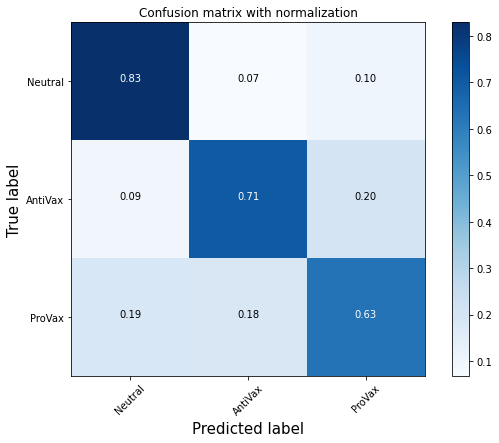

In [37]:
from sklearn.linear_model import LogisticRegression #import

logreg = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
# print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Neutral','AntiVax','ProVax'],normalize=True,
                      title='Confusion matrix with normalization')

Let us wrap this notebook by trying with one more classifier, but reducing the feature vector size to 1000.

Accuracy:  0.6862464183381088


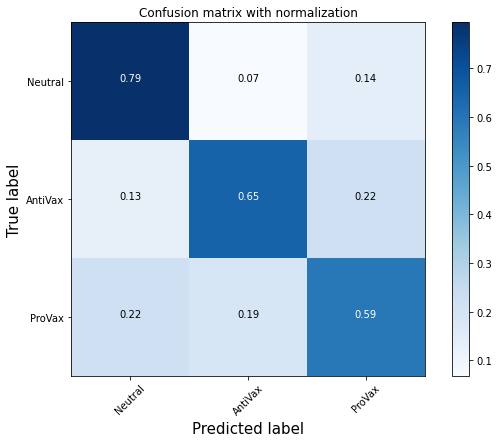

In [38]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) #Step-1
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
# print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Neutral','AntiVax','ProVax'],normalize=True,
                      title='Confusion matrix with normalization')

So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! So, what to choose as the best among these depends on what we are looking for in our usecase! 